# Time Series -Shampoo Sales- ARIMA and SARIMA  

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/ <BR>
https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/

In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
import statsmodels
import statsmodels.api as smt
import statsmodels.formula.api as smf           # statistics and econometrics
import statsmodels.stats.api as sms
import scipy.stats as scs
import scipy.sparse
import random
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
import sklearn

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' #Graphics in SVG format are more sharp and legible
plt.style.use('seaborn-white') #for jupyter dark, change style
sns.set_style("darkgrid")

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import requests

print('Beginning file download with requests')

url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv'
r = requests.get(url)

with open('data/shampoo.csv', 'wb') as series:
    series.write(r.content)

# Retrieve HTTP meta-data
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)

AttributeError: 'RangeIndex' object has no attribute 'inferred_freq' when decomposing <br>
this is becuase of the date index used. there is no clean way to change it in python so change the index in excel after dwonloading and before reading the file. <br>
as the datetime is 1-01, 1-02 which is 1-january and 1-feburary but it is being parsed as 1-jan and 2-jan etc even in excel

          Sales
Month          
1/1/1990  266.0
2/1/1990  145.9
3/1/1990  183.1
4/1/1990  119.3
5/1/1990  180.3


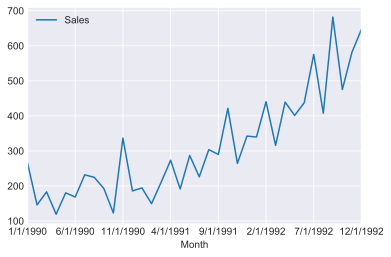

In [4]:
from statsmodels.tsa.arima_model import ARIMA
# load dataset
df = pd.read_csv('data/shampoo.csv', header=0, index_col=0)

# display first few rows
print(df.head()) #print(df.index)
# line plot of dataset
df.plot()

We already know that the data is non-stationary by looking at the preliminary plot but formally there are two ways to check generally:

Plotting Rolling Statistics: The moving average or moving variance and see if it varies with time: any instant ‘t’, taking the average/variance of the last year, i.e. last 12 months. This is more of a visual technique 

Dickey-Fuller Test: A statistical test for checking stationarity. Null hypothesis (Ho) is that the TS is non-stationary. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 

A function can be used for plotting and testing together: standard deviation is plotted instead of variance to keep the unit similar to mean

In [5]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, window=12).mean()
    rolstd = pd.Series.rolling(timeseries, window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(14,10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

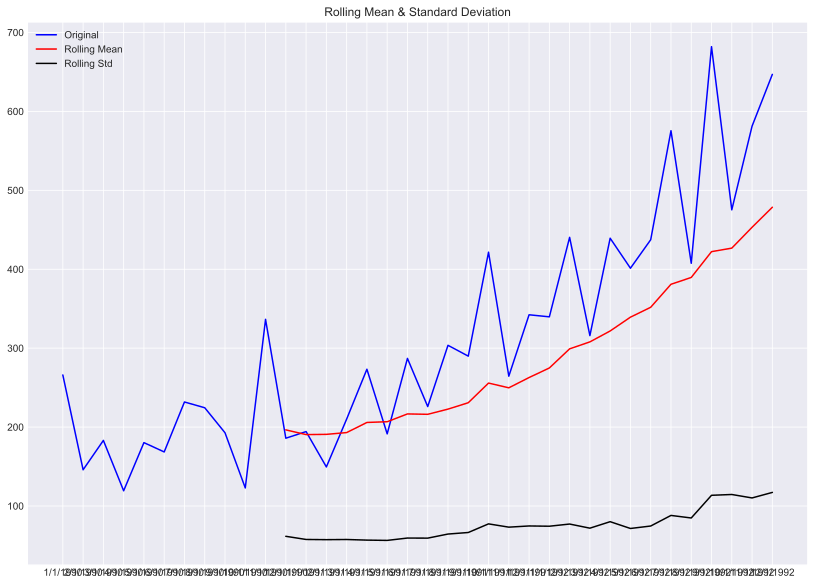

Results of Dickey-Fuller Test:
Test Statistic                  3.060142
p-value                         1.000000
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


In [6]:
test_stationarity(df.Sales)

It looks like there is a trend: upwards increase of sales and possiblity seasonality: sales increase in certain months according to various factors <br>
Trend can be eliminaed by taking transformation: log, square root, cube root etc. While this can be done manually Box-Cox from scipy chooses the appropriate transroamtion appropriately This is appropriate for very straight forward instances with no noise in the data.<br>
Other ways include: <br>
. Aggregation – taking average for a time period like monthly/weekly averages <br>
. Smoothing – taking rolling averages <br>
. Polynomial Fitting – fit a regression model <br>

Smothing includes: Moving Average,  exponentially weighted moving average  <br>

If there is trend and seasonality than the above methods fall short:
Differencing – taking the differece with a particular time lag
Decomposition – modeling both trend and seasonality and removing them from the model.

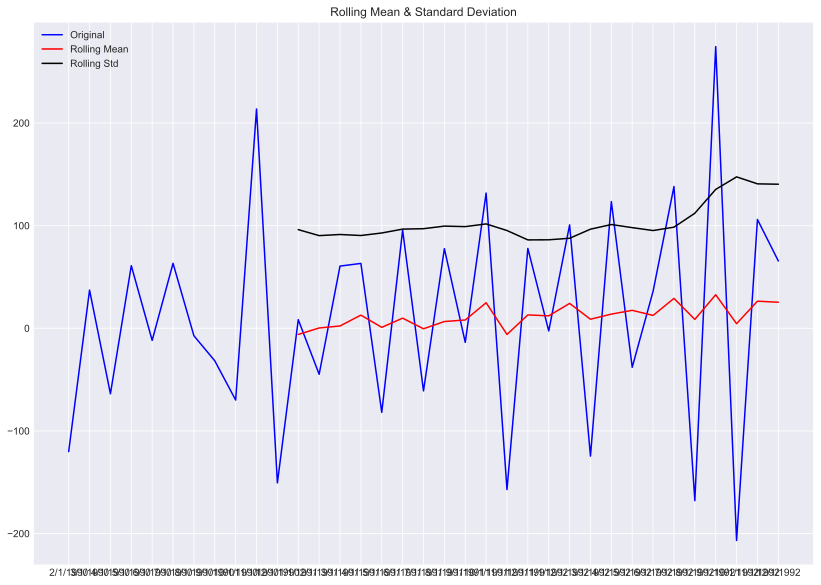

Results of Dickey-Fuller Test:
Test Statistic                -7.249074e+00
p-value                        1.799857e-10
#Lags Used                     1.000000e+00
Number of Observations Used    3.300000e+01
Critical Value (1%)           -3.646135e+00
Critical Value (5%)           -2.954127e+00
Critical Value (10%)          -2.615968e+00
dtype: float64


In [7]:
#ts_log =np.log(df.Sales)
ts_diff = df.Sales - (df.Sales).shift()
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

#simpler way of doing this is below

### Decomposing

(<matplotlib.legend.Legend at 0x185faabba90>, None)

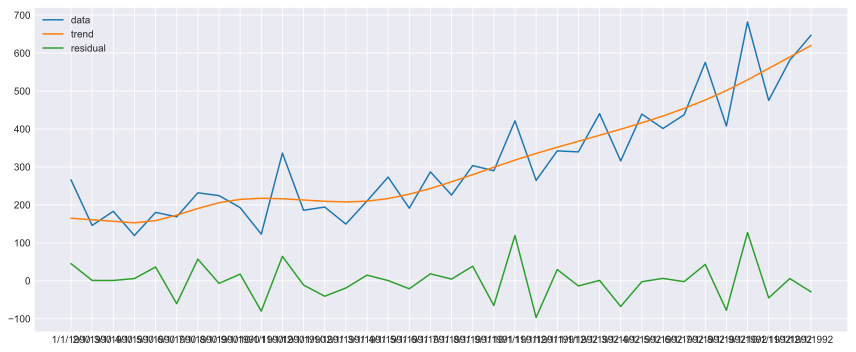

In [8]:
#https://github.com/welch/seasonal
# pip install seasonal works both for python and anaconda
import math
from seasonal import fit_seasons, adjust_seasons

# detrend and deseasonalize
seasons, trend = fit_seasons(df.Sales)
adjusted = adjust_seasons(df.Sales, seasons=seasons)
residual = adjusted - trend

plt.figure(figsize=(12,5))
plt.plot(df.Sales, label='data'), plt.plot(trend, label='trend'), plt.plot(residual, label='residual')
#plt.plot(noisy, label='noisy'), plt.plot(noisy - residual, label='trend+season'), plt.plot(residual, label='residual')
plt.legend(loc='upper left'), plt.tight_layout()

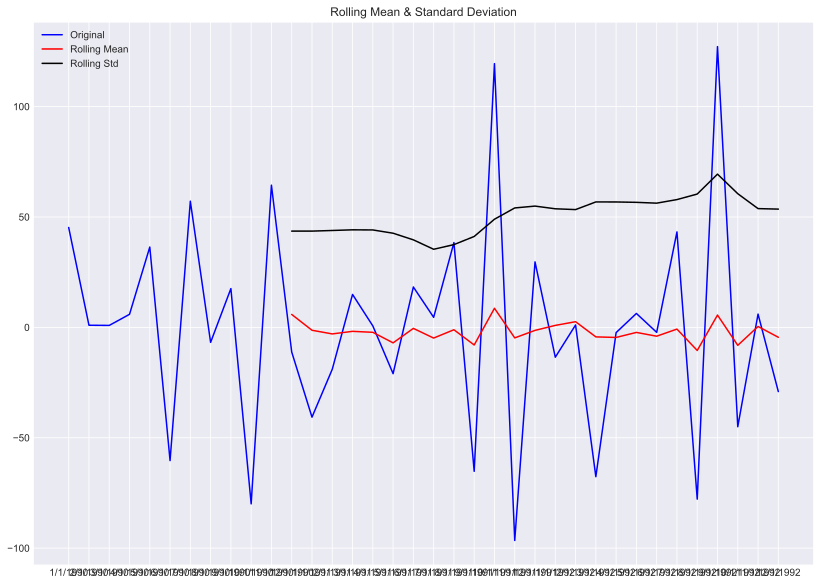

Results of Dickey-Fuller Test:
Test Statistic                 -2.223710
p-value                         0.197753
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


In [9]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [10]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

ARIMA(p,d,q) is a combinaton of ARMA or AR(Autoregressive(p,0,0)) and MA(Moving Average, (0,0,q)) 'p' and 'q' with difference 'd'.<br>

To find 'p', 'q' we look at two plots to determine these numbers:

Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points). <br>

Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4. <br>

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. 
q – The lag value where the ACF chart crosses the upper confidence interval for the first time.

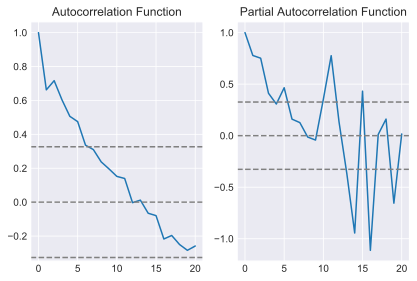

In [11]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(df, nlags=20)
lag_pacf = pacf(df, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df.Sales)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df.Sales)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df.Sales)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df.Sales)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## AR model

Text(0.5, 1.0, 'RSS: 193744.6246')

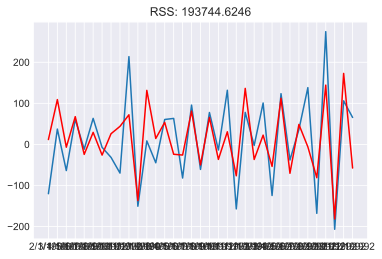

In [12]:
model = ARIMA(df.Sales, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff)**2))

## MA model

Text(0.5, 1.0, 'RSS: 208013.7298')

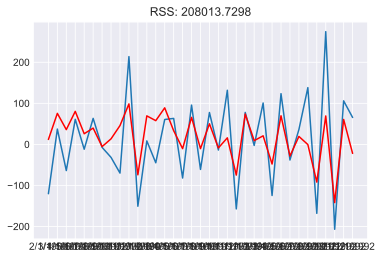

In [13]:
model = ARIMA(df.Sales, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_diff)**2))

## ARIMA model

In [26]:
from itertools import product                    # some useful functions
# setting initial values and some bounds for them
ps = range(0, 3)
d = 1 
qs = range(0, 3)

# creating list with all the possible combinations of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)
def optimizeARIMA(parameters_list, d,):
    """
        Return dataframe with parameters and corresponding AIC
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model, D - seasonal integration order, s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=ARIMA(df.Sales,  order=(param[0], d, param[1])).fit(disp=-1)
        except:
            continue
        aic = model.aic

        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    results = pd.DataFrame(results)
    results.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    results = results.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return results

result_table = optimizeARIMA(parameters_list, d, )
print(result_table.head())


  parameters          aic
0     (0, 2)  2025.962865
1     (0, 1)  2041.226691
2     (2, 0)  2041.466092
3     (1, 0)  2041.598144
4     (0, 0)  2042.237386


Let's inspect the residuals of the model.

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  107
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1008.981
Method:                       css-mle   S.D. of innovations           2954.385
Date:                Thu, 17 Oct 2019   AIC                           2025.963
Time:                        19:19:43   BIC                           2036.654
Sample:                             1   HQIC                          2030.297
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            81.6148     14.790      5.518      0.000      52.628     110.602
ma.L1.D.Sales    -0.3607      0.075     -4.792      0.000      -0.508      -0.213
ma.L2.D.Sales    -0.6393      0.072     

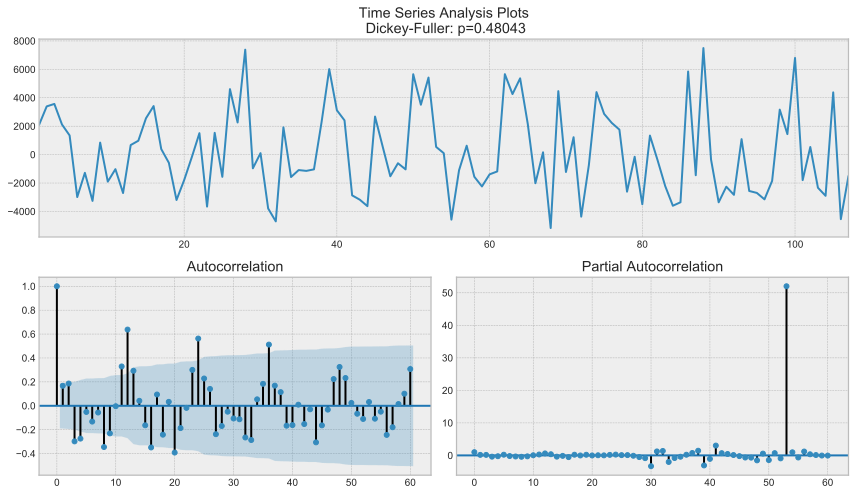

In [27]:
# set the parameters that give the lowest AIC
p, q = result_table.parameters[0]

best_model=ARIMA(df.Sales, order=(p, d, q)).fit(disp=-1)
print(best_model.summary())
print('RSS: %.4f'% sum((best_model.fittedvalues-ts_diff)**2))

tsplot(best_model.resid, lags=60)

In [28]:
#Since the combined model gave best result, lets scale it back to the original values and see how well it performs there. 
#First step would be to store the predicted results as a separate series and observe it.
predictions_ARIMA_diff = pd.Series(best_model.fittedvalues, copy=True)
print( predictions_ARIMA_diff.head())

1      81.614801
2     -95.636560
3   -1198.392949
4   -1929.180254
5   -2146.049918
dtype: float64


Notice that these start from ‘1949-02-01’ and not the first month. <BR>
Why? This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. <BR>
The way to convert the differencing to log scale is to add these differences consecutively to the base number. <BR>
An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:

In [29]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print( predictions_ARIMA_diff_cumsum.head())

1      81.614801
2     -14.021759
3   -1212.414707
4   -3141.594961
5   -5287.644879
dtype: float64


You can quickly do some back of mind calculations using previous output to check if these are correct. <BR>
Next we’ve to add them to base number. For this lets create a series with all values as base number and add the differences to it. This can be done as:

In [30]:
predictions_ARIMA_log = pd.Series(df.Sales.ix[0], index=df.Sales.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

0    6550.000000
1    6631.614801
2    6535.978241
3    5337.585293
4    3408.405039
dtype: float64

Here the first element is base number itself and from thereon the values cumulatively added.<BR> Last step is to take the exponent and compare with the original series.

Text(0.5, 1.0, 'RMSE: inf')

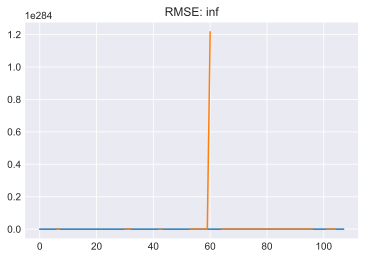

In [31]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df.Sales)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df.Sales)**2)/len(df.Sales)))

# SARIMA 

SARIMA 𝑆(𝑠)  - is responsible for seasonality and equals the season period length of the series which is not looked at in ARIMA <br>
Shampoo sales dataset does not have any seasonality by looking at the graph so its better to change datasets

In [32]:
import requests

print('Beginning file download with requests')

url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
r = requests.get(url)

with open('data/car.csv', 'wb') as series:
    series.write(r.content)

# Retrieve HTTP meta-data
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)

Beginning file download with requests
200
text/plain; charset=utf-8
utf-8


Forecasting of SARIMA requires style index so we need to change the file in excel again as wed did before "Timestamp('1969-01-01 00:00:00')"

In [33]:
df = pd.read_csv('data/car.csv', header=0, index_col=False)
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [34]:
from itertools import product                    # some useful functions
# setting initial values and some bounds for them
ps = range(0, 5)
d=1 
qs = range(0, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [35]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model, D - seasonal integration order, s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df.Sales, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic

        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    results = pd.DataFrame(results)
    results.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    results = results.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return results

result_table = optimizeSARIMA(parameters_list, d, D, s)
print(result_table.head())


     parameters          aic
0  (0, 1, 0, 0)  1502.459139
1  (3, 4, 0, 1)  1502.855099
2  (3, 4, 1, 1)  1503.004825
3  (0, 2, 0, 0)  1503.373790
4  (0, 1, 1, 1)  1503.405372


Let's inspect the residuals of the model.

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(0, 1, 0, 24)   Log Likelihood                -749.230
Date:                            Thu, 17 Oct 2019   AIC                           1502.459
Time:                                    19:29:15   BIC                           1507.297
Sample:                                         0   HQIC                          1504.403
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7275      0.084     -8.618      0.000      -0.893      -0.562
sigma2      3.871e+06   6.02e+05   

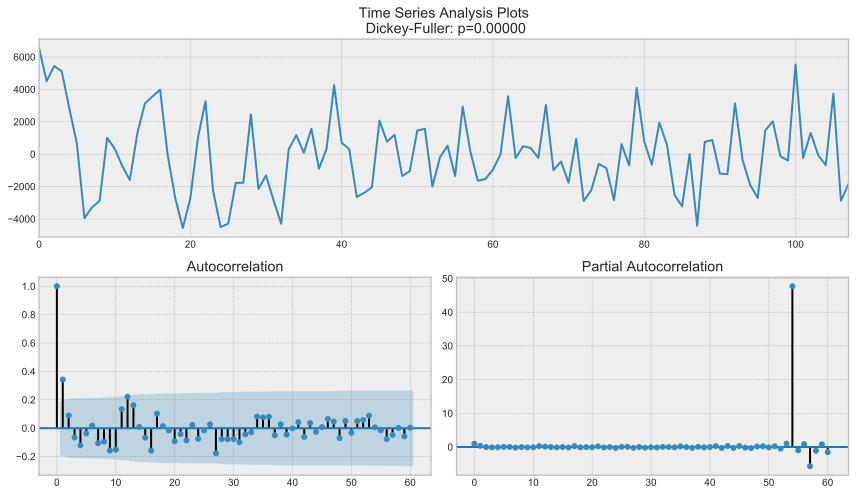

In [36]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df.Sales, order=(p, d, q),  seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

tsplot(best_model.resid, lags=60)